## Objetivo

Usando los datasets de la página de [Anki](https://www.manythings.org/anki/), en la que se disponen de múltiples datasets de traducción de idiomas para entrenar redes neuronales, realizaremos paso a paso un traductor basado en decoders con atención de Bahdanau. Concretamente traduciremos del **italiano al inglés** y del **castellano al inglés**.

El desarrollo de la red que hemos usado como referencia está basada en [este tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) de las páginas de Pytorch.

Este Jupyter Notebook está optimizado para su ejecución en Google Colab.

Utilizaremos un RNN de una capa oculta, con 255 nodos, que entrenaremos durante 100 epochs, para la traducción de frases de hasta 5 caracteres. Todos estos parámetros son configurables.

## Librerías

*El código a continuación importa las librerías y módulos necesarios para trabajar con PyTorch, manipular texto y realizar operaciones de preprocesamiento, y configura el dispositivo de hardware para la ejecución (GPU si está disponible, o CPU si no lo está). También se asegura de que las funciones de impresión y manejo de Unicode sean compatibles con versiones de Python 2 y 3.*

In [ ]:
from __future__ import unicode_literals, print_function, division  # Permite compatibilidad con Python 2 y 3 en impresiones y manejo de Unicode.
from io import open  # Importa el módulo para manejo de archivos.
import unicodedata  # Biblioteca para normalización de texto Unicode.
import re  # Módulo para trabajar con expresiones regulares.
import random  # Módulo para generar números y seleccionar elementos al azar.

import torch  # Biblioteca principal de PyTorch.
import torch.nn as nn  # Importa el módulo de redes neuronales de PyTorch.
from torch import optim  # Importa el optimizador de PyTorch.
import torch.nn.functional as F  # Importa funciones como activaciones, etc.

import numpy as np  # Biblioteca para operaciones numéricas.
from torch.utils.data import TensorDataset, DataLoader, RandomSampler  # Para manipular conjuntos de datos y crear cargadores de datos.

# Configura el dispositivo para ejecutar el código en la GPU si está disponible; si no, en la CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Preparación datos de entrenamiento (descarga y métodos)

*Este código descarga los archivos ita-eng.zip y spa-eng.zip desde la URL, lo guarda en el directorio data/, lo descomprime y luego elimina los archivos zip*

In [ ]:
# Crea la carpeta 'data' si no existe
!mkdir -p data

# Descarga archivos usando wget
!wget -O data/ita-eng.zip https://www.manythings.org/anki/ita-eng.zip
!wget -O data/spa-eng.zip https://www.manythings.org/anki/spa-eng.zip

# Descomprime el archivo descargado
!unzip -o data/ita-eng.zip -d data/
!unzip -o data/spa-eng.zip -d data/

# Renombra el archivo
!mv data/ita.txt data/eng-ita.txt
!mv data/spa.txt data/eng-spa.txt

# Elimina el archivo zip después de la extracción si lo deseas
!rm data/ita-eng.zip
!rm data/spa-eng.zip

--2024-11-22 12:17:30--  https://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8326901 (7.9M) [application/zip]
Saving to: ‘data/ita-eng.zip’

data/ita-eng.zip    100%[===================>]   7.94M  10.8MB/s    in 0.7s    

2024-11-22 12:17:36 (10.8 MB/s) - ‘data/ita-eng.zip’ saved [8326901/8326901]

--2024-11-22 12:17:36--  https://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5420295 (5.2M) [application/zip]
Saving to: ‘data/spa-eng.zip’

data/spa-eng.zip    100%[===================>]   5.17M  8.01MB/s    in 0.6s    

2024-11-22 12:17:37 (8.01 MB/s) - ‘data/spa-eng.zip’ saved [5420295/5420

*El código a continuación define una clase llamada Lang que se utiliza para manejar un idioma específico en un modelo de procesamiento de lenguaje. La clase permite almacenar palabras y asociarlas con índices, además de contar la frecuencia de aparición de cada palabra. La clase también gestiona los tokens especiales de inicio (SOS) y fin de secuencia (EOS).*

In [ ]:
SOS_token = 0  # Token de inicio de secuencia.
EOS_token = 1  # Token de fin de secuencia.

class Lang:
    def __init__(self, name):
        self.name = name  # Nombre del idioma.
        self.word2index = {}  # Diccionario para mapear palabras a índices.
        self.word2count = {}  # Diccionario para contar la frecuencia de palabras.
        self.index2word = {0: "SOS", 1: "EOS"}  # Diccionario para mapear índices a palabras, incluyendo tokens especiales.
        self.n_words = 2  # Contador de palabras, inicia en 2 por los tokens SOS y EOS.

    def addSentence(self, sentence):
        # Divide la oración en palabras y agrega cada una al vocabulario.
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        # Si la palabra no está en el vocabulario, se agrega.
        if word not in self.word2index:
            self.word2index[word] = self.n_words  # Asigna un nuevo índice a la palabra.
            self.word2count[word] = 1  # Inicializa el contador de la palabra.
            self.index2word[self.n_words] = word  # Agrega la palabra al diccionario inverso.
            self.n_words += 1  # Incrementa el número total de palabras.
        else:
            self.word2count[word] += 1  # Incrementa el contador de la palabra si ya existe.


*El código a continuación incluye dos funciones de preprocesamiento de texto. La función unicodeToAscii convierte una cadena Unicode a caracteres ASCII normales eliminando las tildes y otros acentos, mientras que normalizeString convierte el texto a minúsculas, lo recorta y elimina los caracteres que no son letras o signos de puntuación, haciendo que el texto sea más uniforme para el procesamiento posterior.*

In [ ]:
# Convierte una cadena Unicode a ASCII normal, eliminando tildes y acentos.
# Inspirado en https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)  # Descompone caracteres Unicode en su forma base y acentos separados.
        if unicodedata.category(c) != 'Mn'  # Filtra los caracteres que no son marcas diacríticas (como tildes).
    )

# Convierte la cadena a minúsculas, elimina espacios adicionales y elimina caracteres no alfabéticos.
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())  # Convierte a minúsculas, elimina espacios al inicio y final, y normaliza a ASCII.
    s = re.sub(r"([.!?])", r" \1", s)  # Asegura que los signos de puntuación tengan un espacio antes.
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)  # Reemplaza caracteres no alfabéticos ni de puntuación por un espacio.
    return s.strip()  # Elimina espacios adicionales al inicio y final.


*El código siguiente define la función readLangs, que lee un archivo de texto con pares de frases en dos idiomas, los normaliza y los organiza en pares de entrada y salida. Si se especifica reverse=True, invierte los pares de frases y asigna los idiomas correspondientes a las instancias de la clase Lang.*

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")  # Imprime un mensaje indicando que se están leyendo las líneas.

    # Lee el archivo y lo divide en líneas individuales.
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')

    # Divide cada línea en pares (oración en idioma 1 y oración en idioma 2) y las normaliza.
#    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]

    # Si se especifica `reverse=True`, invierte los pares y asigna los idiomas.
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]  # Invierte cada par de frases.
        input_lang = Lang(lang2)  # El idioma de entrada se convierte en `lang2`.
        output_lang = Lang(lang1)  # El idioma de salida se convierte en `lang1`.
    else:
        input_lang = Lang(lang1)  # El idioma de entrada es `lang1`.
        output_lang = Lang(lang2)  # El idioma de salida es `lang2`.

    return input_lang, output_lang, pairs  # Retorna las instancias de los idiomas y los pares de frases.


*El código siguiente define la constante MAX_LENGTH para limitar la longitud de las frases y dos funciones: filterPair, que verifica si un par de frases cumple con ciertas condiciones de longitud, y filterPairs, que filtra una lista de pares de frases usando la función filterPair.*

In [ ]:

MAX_LENGTH = 5         # Longitud máxima permitida para las frases.


# Definimos prefijos comunes en inglés (lang1) para limitar la cantidad de pares en el set de datos
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

# Función que filtra las frases según longitud y prefijos según el idioma de entrada
def filterPair(p, reverse):
    if reverse:
        # Cuando la entrada es lang2 y salida lang1
        return len(p[0].split(' ')) < MAX_LENGTH and \
               len(p[1].split(' ')) < MAX_LENGTH and \
               p[1].startswith(eng_prefixes)  # Filtra según los prefijos en inglés
    else:
        # Cuando la entrada es lang1 y salida lang2
        return len(p[0].split(' ')) < MAX_LENGTH and \
               len(p[1].split(' ')) < MAX_LENGTH and \
               p[0].startswith(eng_prefixes)  # Filtra según los prefijos en inglés


# Filtra los pares de frases usando la función `filterPair`.
def filterPairs(pairs, reverse):
    return [pair for pair in pairs if filterPair(pair, reverse)]  # Retorna solo los pares que cumplen las condiciones.



*El código a continuación define la función prepareData, que prepara los datos para el entrenamiento de un modelo de traducción. La función lee un archivo con pares de frases, los filtra, cuenta las palabras en cada idioma y devuelve las instancias de los objetos Lang y la lista de pares de frases. Finalmente, se imprime un par de frases al azar de los datos preparados.*

In [ ]:
# Función para preparar el conjunto de datos
def prepareData(lang1, lang2, reverse=False):
    # Lee el archivo con las frases y devuelve los objetos de idioma y los pares de frases.
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))  # Imprime la cantidad de pares de frases leídos.

    # Filtra los pares de frases según las condiciones establecidas.
    pairs = filterPairs(pairs, reverse)
    print("Trimmed to %s sentence pairs" % len(pairs))  # Imprime la cantidad de pares después de filtrar.

    print("Counting words...")
    # Cuenta las palabras en cada frase de los pares y las agrega a los diccionarios de palabras.
    for pair in pairs:
        input_lang.addSentence(pair[0])  # Agrega las palabras de la frase de entrada.
        output_lang.addSentence(pair[1])  # Agrega las palabras de la frase de salida.

    print("Counted words:")
    # Imprime el nombre del idioma y el número de palabras únicas.
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    # Retorna los objetos de idioma y los pares de frases.
    return input_lang, output_lang, pairs


## Modelo con atención (métodos)

Definimos un modelo seq2seq con atención de Bahdanau que consta de un codificador y un decodificador con atención.

*El código a continuación define una clase EncoderRNN, que representa el codificador de una red neuronal recurrente (RNN) utilizada en modelos de traducción de secuencias. Este codificador convierte secuencias de palabras en representaciones vectoriales que pueden ser utilizadas por un decodificador. Se utiliza un embedding para convertir los índices de las palabras en vectores densos y una capa GRU (Gated Recurrent Unit) para procesar la secuencia.*

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()  # Inicializa la clase base nn.Module
        self.hidden_size = hidden_size  # Tamaño de los vectores de estado oculto

        # Capa de embedding para convertir índices de palabras en vectores densos
        self.embedding = nn.Embedding(input_size, hidden_size)

        # Capa GRU para procesar la secuencia de embeddings, con salida de tamaño `hidden_size`
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=1, batch_first=True)

        # Capa de dropout para regularización, que ayuda a prevenir el overfitting
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        # Aplica la capa de embedding seguida del dropout a la entrada
        embedded = self.dropout(self.embedding(input))

        # Pasa el embedding a través de la capa GRU, obteniendo la salida y el último estado oculto
        output, hidden = self.gru(embedded)

        # Devuelve la salida y el estado oculto final
        return output, hidden


*El código a continuación implementa un AttnDecoderRNN, que es un decodificador de red neuronal recurrente con mecanismo de atención tipo Bahdanau. Este decodificador permite a la red enfocarse en diferentes partes de la secuencia de entrada en cada paso de la decodificación, lo que mejora la capacidad de la red para manejar secuencias largas y complejas.*

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        # Matrices de pesos para calcular los scores de atención
        self.Wa = nn.Linear(hidden_size, hidden_size)  # Para transformar la consulta (hidden state)
        self.Ua = nn.Linear(hidden_size, hidden_size)  # Para transformar las claves (encoder outputs)
        self.Va = nn.Linear(hidden_size, 1)  # Para calcular el score final de atención

    def forward(self, query, keys):
        # Calcula los scores de atención sumando y aplicando activación tanh
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)  # Ajusta la forma del tensor para softmax

        # Calcula los pesos de atención aplicando softmax sobre los scores
        weights = F.softmax(scores, dim=-1)
        # Calcula el contexto multiplicando los pesos por las claves
        context = torch.bmm(weights, keys)

        return context, weights  # Devuelve el contexto y los pesos de atención

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size) # Capa de embedding para las palabras de salida
        self.attention = BahdanauAttention(hidden_size) # Mecanismo de atención Bahdanau
        self.gru = nn.GRU(2*hidden_size, hidden_size, num_layers=1, batch_first=True) # Capa GRU que toma en cuenta el contexto de atención
        self.out = nn.Linear(hidden_size, output_size) # Capa lineal para generar la salida
        self.dropout = nn.Dropout(dropout_p) # Dropout para regularización

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)  # Tamaño del lote
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)  # Token de inicio
        decoder_hidden = encoder_hidden  # Estado oculto inicial proporcionado por el codificador
        decoder_outputs = []  # Lista para almacenar las salidas del decodificador
        attentions = []  # Lista para almacenar los pesos de atención

        # Proceso de decodificación secuencial
        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)  # Agrega la salida actual a la lista
            attentions.append(attn_weights)  # Agrega los pesos de atención

            if target_tensor is not None:
                # Teacher forcing: usa el objetivo real como la siguiente entrada
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Sin teacher forcing: usa su propia predicción como la siguiente entrada
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # Desconecta del historial de cálculo

        decoder_outputs = torch.cat(decoder_outputs, dim=1)  # Concatena las salidas
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)  # Aplica softmax logarítmico
        attentions = torch.cat(attentions, dim=1)  # Concatena las atenciones

        return decoder_outputs, decoder_hidden, attentions  # Devuelve las salidas, estado oculto y atenciones

    def forward_step(self, input, hidden, encoder_outputs):
        # Genera el embedding de la entrada y aplica dropout
        embedded = self.dropout(self.embedding(input))
        query = hidden.permute(1, 0, 2)  # Permuta para que tenga la forma adecuada
        context, attn_weights = self.attention(query, encoder_outputs)  # Calcula el contexto y pesos de atención
        input_gru = torch.cat((embedded, context), dim=2)  # Concatena el embedding y el contexto

        # Pasa la entrada a través de la GRU
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)  # Genera la salida proyectada

        return output, hidden, attn_weights  # Devuelve la salida, estado oculto y pesos de atención


## Entrenamiento (métodos)

*El código a continuación define funciones para convertir frases en tensores de índices y un método para crear un DataLoader con datos de entrada y salida preparados para entrenamiento. Estas funciones permiten estructurar los datos de texto en un formato que puede ser utilizado por modelos de aprendizaje profundo.*

In [ ]:
def indexesFromSentence(lang, sentence):
    # Convierte una oración en una lista de índices según el diccionario de la clase Lang.
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    # Convierte una lista de índices en un tensor y agrega el token de fin de oración (EOS).
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)  # Crea un tensor con la forma (1, longitud)

def tensorsFromPair(pair):
    # Crea tensores de entrada y salida a partir de un par de frases (entrada y objetivo).
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size, lang_1, lang_2):
    # Prepara los datos de entrenamiento creando un DataLoader a partir de pares de frases.
    input_lang, output_lang, pairs = prepareData(lang_1, lang_2, REVERSE_LANG)  # Lee y prepara los datos.

    n = len(pairs)  # Número de pares de frases
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)  # Matriz para almacenar IDs de entrada
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)  # Matriz para almacenar IDs de salida

    for idx, (inp, tgt) in enumerate(pairs):
        # Convierte las frases de entrada y salida en índices y las almacena.
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)  # Agrega token de fin de oración
        tgt_ids.append(EOS_token)  # Agrega token de fin de oración
        input_ids[idx, :len(inp_ids)] = inp_ids  # Inserta los IDs de entrada en la matriz
        target_ids[idx, :len(tgt_ids)] = tgt_ids  # Inserta los IDs de salida en la matriz

    # Crea un dataset de tensores y lo convierte en un DataLoader con muestreo aleatorio.
    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)  # Muestra lotes aleatoriamente
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)  # Crea DataLoader
    return input_lang, output_lang, train_dataloader  # Retorna el lenguaje de entrada, salida y DataLoader


*El código a continuación define una función que entrena el modelo en una época completa, usando un DataLoader para iterar sobre los lotes de datos y actualizar los pesos del encoder y decoder basados en la pérdida calculada.*

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):
    # Entrena el modelo durante una época completa usando los datos del dataloader.

    total_loss = 0  # Inicializa la variable para almacenar la pérdida total de la época.
    for data in dataloader:  # Itera sobre cada lote de datos en el dataloader.
        input_tensor, target_tensor = data  # Obtiene el tensor de entrada y el tensor objetivo.

        # Reinicia los gradientes de los optimizadores para el encoder y el decoder.
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # Realiza la pasada hacia adelante del encoder.
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        # Realiza la pasada hacia adelante del decoder, usando la salida del encoder y el estado oculto.
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        # Calcula la pérdida entre las salidas del decoder y el tensor objetivo.
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),  # Ajusta la forma de las salidas.
            target_tensor.view(-1)  # Ajusta la forma del tensor objetivo.
        )
        loss.backward()  # Realiza la retropropagación para calcular los gradientes.

        # Actualiza los parámetros del encoder y el decoder usando los optimizadores.
        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()  # Acumula la pérdida para el cálculo del promedio.

    # Retorna la pérdida promedio de la época.
    return total_loss / len(dataloader)


*El código a continuación define dos funciones auxiliares que ayudan a medir y mostrar el tiempo transcurrido y estimar el tiempo restante durante el entrenamiento.*

In [ ]:
import time
import math

# Convierte los segundos a un formato de minutos y segundos.
def asMinutes(s):
    m = math.floor(s / 60)  # Calcula los minutos enteros.
    s -= m * 60  # Resta los minutos completos para obtener los segundos restantes.
    return '%dm %ds' % (m, s)  # Devuelve el tiempo en formato "Xm Ys".

# Calcula el tiempo transcurrido desde un momento dado y estima el tiempo restante.
def timeSince(since, percent):
    now = time.time()  # Obtiene el tiempo actual.
    s = now - since  # Calcula el tiempo transcurrido desde el momento inicial.
    es = s / percent  # Estima el tiempo total esperado dividiendo el tiempo transcurrido por el porcentaje completado.
    rs = es - s  # Calcula el tiempo restante.
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))  # Devuelve el tiempo transcurrido y el tiempo restante en formato "Xm Ys (- Xm Ys)".


*El código a continuación define la función showPlot que se utiliza para graficar los puntos de pérdida acumulada durante el entrenamiento de un modelo.*

*La función showPlot toma un conjunto de puntos (como las pérdidas registradas durante el entrenamiento) y los grafica en un gráfico de línea. Utiliza MultipleLocator para definir intervalos regulares en el eje y y plt.plot() para dibujar los datos.*

In [ ]:
%matplotlib inline
# Muestra los gráficos directamente en el notebook.

import matplotlib.pyplot as plt
plt.switch_backend('agg')  # Cambia el backend de Matplotlib para no mostrar gráficos en vivo.
import matplotlib.ticker as ticker  # Importa herramientas para manipular los ejes de las gráficas.
import numpy as np

def showPlot(points):
    plt.figure()  # Crea una nueva figura.
    fig, ax = plt.subplots()  # Crea una figura y un eje de la gráfica.
    # Establece un localizador que coloca las marcas en intervalos regulares en el eje y.
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)  # Aplica el localizador al eje y.
    plt.plot(points)  # Dibuja la gráfica de los puntos.
    plt.show()


*El código a continuación define la función train, que entrena un modelo de codificador-decodificador (encoder-decoder) durante un número determinado de épocas. Se utilizan optimizadores y una función de pérdida para ajustar los parámetros del modelo y registrar el progreso.*

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()  # Marca el tiempo de inicio del entrenamiento.
    plot_losses = []  # Lista para almacenar las pérdidas que se usarán en el gráfico.
    print_loss_total = 0  # Acumula la pérdida total para imprimir cada `print_every`.
    plot_loss_total = 0  # Acumula la pérdida total para graficar cada `plot_every`.

    # Inicializa los optimizadores para el codificador y el decodificador.
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()  # Función de pérdida: Negative Log-Likelihood.

    # Itera a través de las épocas de entrenamiento.
    for epoch in range(1, n_epochs + 1):
        # Entrena una época y devuelve la pérdida promedio.
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss  # Acumula la pérdida para imprimir.
        plot_loss_total += loss  # Acumula la pérdida para el gráfico.

        # Imprime el progreso del entrenamiento cada `print_every` épocas.
        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every  # Calcula la pérdida promedio.
            print_loss_total = 0  # Resetea la pérdida acumulada.
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),  # Imprime el tiempo transcurrido.
                                         epoch, epoch / n_epochs * 100, print_loss_avg))  # Imprime la época y la pérdida promedio.

        # Agrega la pérdida promedio al gráfico cada `plot_every` épocas.
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every  # Calcula la pérdida promedio para graficar.
            plot_losses.append(plot_loss_avg)  # Añade la pérdida al gráfico.
            plot_loss_total = 0  # Resetea la pérdida acumulada para el gráfico.

    showPlot(plot_losses)  # Llama a la función para mostrar el gráfico de pérdidas.


## Evaluación (métodos)

*El código a continuación define la función evaluate, que se utiliza para evaluar la salida de un modelo de traducción secuencia a secuencia (seq2seq) dado un encoder y un decoder, junto con una frase de entrada.*

*La función evaluate toma un encoder y decoder, junto con una frase de entrada, y genera una traducción palabra por palabra. Utiliza torch.no_grad() para evitar el cálculo de gradientes y reduce la carga computacional. El proceso incluye la conversión de la frase en un tensor, la obtención de la salida del encoder y decoder, y la construcción de la secuencia de palabras decodificadas hasta que se alcanza el token de fin de secuencia (EOS).*

In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():  # Desactiva el cálculo de gradientes para ahorrar memoria y acelerar la evaluación.
        # Convierte la frase de entrada en un tensor de índices.
        input_tensor = tensorFromSentence(input_lang, sentence)

        # Pasa la frase a través del encoder y obtiene las salidas y el estado oculto.
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        # Pasa las salidas del encoder al decoder y obtiene las predicciones.
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        # Obtiene los índices de las palabras con las puntuaciones más altas.
        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()  # Elimina dimensiones innecesarias.

        decoded_words = []  # Lista para almacenar las palabras decodificadas.
        for idx in decoded_ids:  # Itera sobre los índices decodificados.
            if idx.item() == EOS_token:  # Verifica si se ha alcanzado el token de fin de secuencia (EOS).
                decoded_words.append('<EOS>')
                break  # Termina la iteración si se encuentra el token EOS.
            # Añade la palabra correspondiente al índice actual a la lista de palabras decodificadas.
            decoded_words.append(output_lang.index2word[idx.item()])

    # Retorna la lista de palabras decodificadas y las atenciones del decoder.
    return decoded_words, decoder_attn


*El código a continuación define la función evaluateRandomly, que evalúa el desempeño del modelo de traducción secuencia a secuencia de manera aleatoria con n ejemplos de las frases disponibles.*

*La función evaluateRandomly selecciona al azar n pares de frases de los datos de entrada y evalúa el modelo de traducción utilizando la función evaluate. Luego, imprime la frase de entrada original, la frase de salida esperada y la salida generada por el modelo, mostrando cómo el modelo traduce y si se aproxima a la respuesta correcta.*

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    # Itera `n` veces para evaluar el modelo con diferentes ejemplos.
    for i in range(n):
        # Selecciona aleatoriamente un par de frases (entrada y salida) de la lista de pares.
        pair = random.choice(pairs)
        print('>', pair[0])  # Imprime la frase de entrada.
        print('=', pair[1])  # Imprime la frase de salida esperada.

        # Evalúa el modelo con la frase de entrada y obtiene las palabras de la salida.
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)

        # Convierte la lista de palabras de salida en una frase completa.
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)  # Imprime la frase generada por el modelo.
        print('')  # Imprime una línea en blanco para separar los ejemplos.


*El código a continuación define los métodos para la evaluación de un modelo de traducción basado en RNN y visualiza la atención que el modelo aplica a las palabras de la entrada mientras genera la salida. Primero, evalúa la frase de entrada, luego muestra la frase de salida generada y representa la matriz de atención con un gráfico para visualizar qué palabras de la entrada fueron más relevantes para cada palabra generada en la salida.*

- *showAttention se encarga de representar la matriz de atención visualmente, mostrando qué partes de la frase de entrada influyeron más en cada palabra de la salida.*

- *evaluateAndShowAttention evalúa una frase de entrada, imprime la traducción generada por el modelo y llama a showAttention para visualizar la atención.*

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Crea una figura para mostrar la matriz de atención
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Muestra la matriz de atención como una imagen con un mapa de color 'bone'
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Configura las etiquetas de los ejes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)  # Etiquetas en el eje X
    ax.set_yticklabels([''] + output_words)  # Etiquetas en el eje Y

    # Muestra una etiqueta en cada tick (marcador de eje)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Muestra el gráfico
    plt.show()

def evaluateAndShowAttention(input_sentence):
    # Evalúa el modelo con la frase de entrada y obtiene las palabras de salida y la matriz de atención
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)  # Imprime la frase de entrada
    print('output =', ' '.join(output_words))  # Imprime la frase de salida generada
    # Muestra la atención aplicada en la traducción
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])




## Ejecución (entrenamiento y evaluación)

En esta parte, ya teniendo todos los métodos necesarios definidos, procederemos al entrenamiento del modelo y a la evaluación de este una vez entrenado.

Podemos cargar los datos para la traducción Italiano-->Inglés o para Español-->Inglés y luego proceder al entrenamiento y evaluación del modelo.

### Italiano-->Inglés

*El código siguiente define la constante REVERSE_LANG para establecer el sentido de traducción y los idiomas con los que realizará la traducción. En este caso Italiano a Inglés.*

In [ ]:
# CASO ITALIANO --> INGLÉS
REVERSE_LANG = True    #True para lang2 → lang1 (inglés), y False para lang1 → lang2.
LANG_1 = 'eng'
LANG_2 = 'ita'

#### Carga de datos y preprocesamiento

*El código siguiente carga y preprocesa el set de idiomas seleccionado*

In [ ]:
input_lang, output_lang, pairs = prepareData(LANG_1, LANG_2, REVERSE_LANG)
print(random.choice(pairs))  # Imprime un par de frases al azar de los datos preparados.

Reading lines...
Read 377937 sentence pairs
Trimmed to 12209 sentence pairs
Counting words...
Counted words:
ita 2762
eng 1416
['tu sei malvagio', 'you re evil']


#### Ejecución del entrenamiento

*Este código configura un encoder y un decoder **con atención**, y entrena la red en un conjunto de datos de frases para traducir de un idioma a otro. El entrenamiento se realiza durante 100 épocas, y se imprime la pérdida promedio en cada época mientras se actualiza una gráfica de pérdidas para seguir el progreso del entrenamiento.*

Reading lines...
Read 377937 sentence pairs
Trimmed to 12209 sentence pairs
Counting words...
Counted words:
ita 2762
eng 1416
0m 15s (- 26m 4s) (1 1%) 1.8760
0m 33s (- 27m 33s) (2 2%) 1.1042
0m 49s (- 26m 54s) (3 3%) 0.6370
1m 6s (- 26m 33s) (4 4%) 0.3283
1m 24s (- 26m 54s) (5 5%) 0.1941
1m 42s (- 26m 40s) (6 6%) 0.1364
1m 58s (- 26m 9s) (7 7%) 0.1093
2m 15s (- 26m 1s) (8 8%) 0.0956
2m 32s (- 25m 41s) (9 9%) 0.0892
2m 49s (- 25m 23s) (10 10%) 0.0853
3m 6s (- 25m 12s) (11 11%) 0.0811
3m 24s (- 24m 58s) (12 12%) 0.0791
3m 40s (- 24m 38s) (13 13%) 0.0821
3m 57s (- 24m 19s) (14 14%) 0.0763
4m 14s (- 24m 3s) (15 15%) 0.0747
4m 31s (- 23m 47s) (16 16%) 0.0735
4m 48s (- 23m 28s) (17 17%) 0.0731
5m 5s (- 23m 12s) (18 18%) 0.0747
5m 22s (- 22m 56s) (19 19%) 0.0717
5m 40s (- 22m 43s) (20 20%) 0.0698
5m 57s (- 22m 26s) (21 21%) 0.0696
6m 14s (- 22m 9s) (22 22%) 0.0694
6m 31s (- 21m 51s) (23 23%) 0.0676
6m 48s (- 21m 33s) (24 24%) 0.0682
7m 5s (- 21m 17s) (25 25%) 0.0674
7m 22s (- 20m 58s) (26 26

<Figure size 640x480 with 0 Axes>

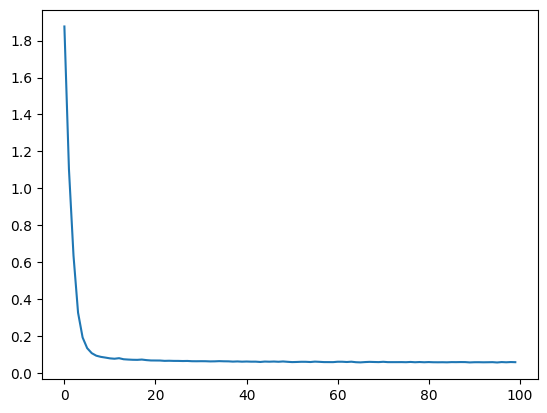

In [ ]:
%matplotlib inline
# Asegura que los gráficos se muestren dentro del notebook.

# Define el tamaño de la capa oculta, el tamaño del lote y el número de épocas.
hidden_size = 256  # Aquí se define el tamaño de la capa oculta como 256 nodos
batch_size = 32  # Define el tamaño del lote: número de ejemplos procesados simultáneamente en cada paso de entrenamiento.
epochs = 100     # Número de épocas de entrenamiento: cantidad de veces que el modelo pasará por todo el conjunto de datos.

# Obtiene el dataloader con frases en los idiomas especificados y convierte las frases en tensores.
input_lang, output_lang, train_dataloader = get_dataloader(batch_size, LANG_1, LANG_2)

# Inicializa el modelo de encoder con el tamaño de la entrada igual al número de palabras únicas en el idioma de entrada.
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)

# Inicializa el modelo de decoder con atención.
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

# Entrena el modelo, imprimiendo el error de entrenamiento y actualizando la gráfica de pérdida en cada época.
train(train_dataloader, encoder, decoder, epochs, print_every=1, plot_every=1)


*El código siguiente se utiliza para evaluar el rendimiento del modelo previamente entrenado en datos de prueba al elegir frases al azar del conjunto de datos.*

*Este fragmento de código coloca al encoder y decoder en modo de evaluación (sin gradientes), lo que es más eficiente y adecuado para hacer predicciones. Luego, llama a evaluateRandomly para que seleccione 10 frases al azar del conjunto de datos y las traduzca, mostrando tanto la frase de entrada (>) como la traducción de salida generada por el modelo (<) y la traducción correcta (=)*

#### Evaluación de resultados

In [ ]:
encoder.eval()  # Configura el modelo encoder en modo de evaluación (desactiva el cálculo de gradientes).
decoder.eval()  # Configura el modelo decoder en modo de evaluación.

# Llama a la función para evaluar el modelo de forma aleatoria en 10 frases del conjunto de datos.
evaluateRandomly(encoder, decoder)


> sto ancora lavorando
= i m still working
< i m still working <EOS>

> io sono pulito
= i m clean
< i m clean <EOS>

> tu non sei diversa
= you re no different
< you re no different <EOS>

> sono tuoi
= they re yours
< they re yours <EOS>

> sono ancora frustrata
= i m still frustrated
< i m still frustrated <EOS>

> sei insolito
= you re unusual
< you re unusual <EOS>

> io sono una masochista
= i m a masochist
< i m a masochist <EOS>

> siamo veramente ubriachi
= we re really drunk
< we re really drunk <EOS>

> io sono molto nervoso
= i m very nervous
< i m very nervous <EOS>

> ho quasi trent anni
= i m almost thirty
< i m almost thirty <EOS>



*El código a continuación ejecuta la evaluación de un modelo de traducción basado en RNN y visualiza la atención que el modelo aplica a las palabras de la entrada mientras genera la salida. Primero, evalúa la frase de entrada, luego muestra la frase de salida generada y representa la matriz de atención con un gráfico para visualizar qué palabras de la entrada fueron más relevantes para cada palabra generada en la salida.*

input = sei una studentessa
output = you are a student <EOS>


C:\Users\aalon\AppData\Local\Temp\ipykernel_11676\131804528.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)  # Etiquetas en el eje X
C:\Users\aalon\AppData\Local\Temp\ipykernel_11676\131804528.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)  # Etiquetas en el eje Y


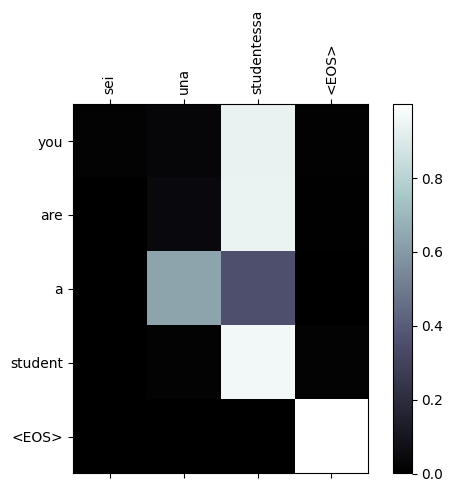

input = ho finito di lavorare
output = i m done working <EOS>


C:\Users\aalon\AppData\Local\Temp\ipykernel_11676\131804528.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)  # Etiquetas en el eje X
C:\Users\aalon\AppData\Local\Temp\ipykernel_11676\131804528.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)  # Etiquetas en el eje Y


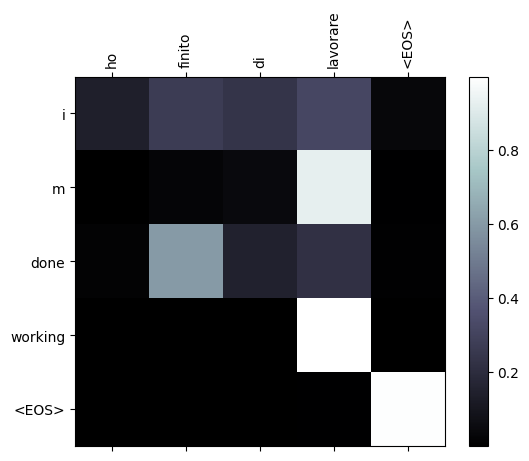

In [ ]:
# Evalúa y muestra la atención para varias frases de ejemplo
if REVERSE_LANG:    # True para lang2 → lang1
  if LANG_2=='ita':
      evaluateAndShowAttention('sei una studentessa')
      evaluateAndShowAttention('ho finito di lavorare')
  else:
      evaluateAndShowAttention('usted es la mejor')
      evaluateAndShowAttention('estoy bastante cansado')
else:               # False para lang1 → lang2
    evaluateAndShowAttention('you re very stylish')
    evaluateAndShowAttention('he is very brave')

### Español-->Inglés

*El código siguiente define la constante REVERSE_LANG para establecer el sentido de traducción y los idiomas con los que realizará la traducción. En este caso Español a Inglés.*

In [ ]:
# CASO ESPAÑOL --> INGLÉS
REVERSE_LANG = True    #True para lang2 → lang1 (inglés), y False para lang1 → lang2.
LANG_1 = 'eng'
LANG_2 = 'spa'

#### Carga de datos y preprocesamiento

*El código siguiente carga y preprocesa el set de idiomas seleccionado*

In [ ]:
input_lang, output_lang, pairs = prepareData(LANG_1, LANG_2, REVERSE_LANG)
print(random.choice(pairs))  # Imprime un par de frases al azar de los datos preparados.

Reading lines...
Read 141543 sentence pairs
Trimmed to 2802 sentence pairs
Counting words...
Counted words:
spa 1524
eng 1036
['soy fotografo', 'i m a photographer']


#### Ejecución del entrenamiento

*Este código configura un encoder y un decoder **con atención**, y entrena la red en un conjunto de datos de frases para traducir de un idioma a otro. El entrenamiento se realiza durante 100 épocas, y se imprime la pérdida promedio en cada época mientras se actualiza una gráfica de pérdidas para seguir el progreso del entrenamiento.*

Reading lines...
Read 141543 sentence pairs
Trimmed to 2802 sentence pairs
Counting words...
Counted words:
spa 1524
eng 1036
0m 10s (- 18m 3s) (1 1%) 2.8859
0m 17s (- 14m 25s) (2 2%) 1.8566
0m 23s (- 12m 30s) (3 3%) 1.5321
0m 29s (- 11m 55s) (4 4%) 1.2917
0m 35s (- 11m 9s) (5 5%) 1.0845
0m 41s (- 10m 54s) (6 6%) 0.8971
0m 47s (- 10m 29s) (7 7%) 0.7268
0m 53s (- 10m 19s) (8 8%) 0.5739
0m 59s (- 10m 1s) (9 9%) 0.4441
1m 5s (- 9m 49s) (10 10%) 0.3433
1m 11s (- 9m 38s) (11 11%) 0.2522
1m 17s (- 9m 25s) (12 12%) 0.1950
1m 23s (- 9m 19s) (13 13%) 0.1555
1m 29s (- 9m 7s) (14 14%) 0.1293
1m 35s (- 9m 1s) (15 15%) 0.1109
1m 41s (- 8m 50s) (16 16%) 0.0964
1m 47s (- 8m 45s) (17 17%) 0.0893
1m 53s (- 8m 34s) (18 18%) 0.0815
1m 59s (- 8m 28s) (19 19%) 0.0794
2m 4s (- 8m 19s) (20 20%) 0.0732
2m 10s (- 8m 10s) (21 21%) 0.0725
2m 16s (- 8m 5s) (22 22%) 0.0691
2m 22s (- 7m 56s) (23 23%) 0.0686
2m 28s (- 7m 51s) (24 24%) 0.0667
2m 34s (- 7m 43s) (25 25%) 0.0639
2m 40s (- 7m 38s) (26 26%) 0.0607
2m 46s 

<Figure size 640x480 with 0 Axes>

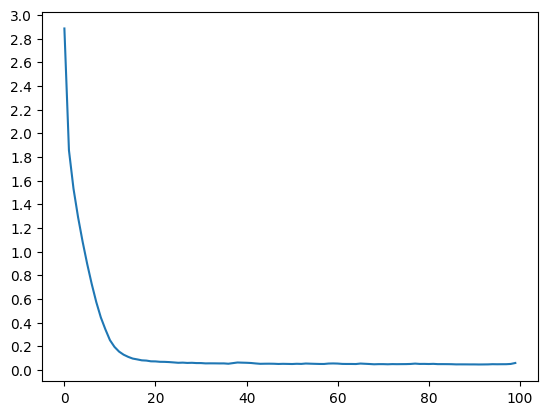

In [ ]:
%matplotlib inline
# Asegura que los gráficos se muestren dentro del notebook.

# Define el tamaño de la capa oculta, el tamaño del lote y el número de épocas.
hidden_size = 256  # Aquí se define el tamaño de la capa oculta como 256 nodos
batch_size = 32  # Define el tamaño del lote: número de ejemplos procesados simultáneamente en cada paso de entrenamiento.
epochs = 100     # Número de épocas de entrenamiento: cantidad de veces que el modelo pasará por todo el conjunto de datos.

# Obtiene el dataloader con frases en los idiomas especificados y convierte las frases en tensores.
input_lang, output_lang, train_dataloader = get_dataloader(batch_size, LANG_1, LANG_2)

# Inicializa el modelo de encoder con el tamaño de la entrada igual al número de palabras únicas en el idioma de entrada.
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)

# Inicializa el modelo de decoder con atención.
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

# Entrena el modelo, imprimiendo el error de entrenamiento y actualizando la gráfica de pérdida en cada época.
train(train_dataloader, encoder, decoder, epochs, print_every=1, plot_every=1)


*El código siguiente se utiliza para evaluar el rendimiento del modelo previamente entrenado en datos de prueba al elegir frases al azar del conjunto de datos.*

*Este fragmento de código coloca al encoder y decoder en modo de evaluación (sin gradientes), lo que es más eficiente y adecuado para hacer predicciones. Luego, llama a evaluateRandomly para que seleccione 10 frases al azar del conjunto de datos y las traduzca, mostrando tanto la frase de entrada (>) como la traducción de salida generada por el modelo (<) y la traducción correcta (=)*

#### Evaluación de resultados

In [ ]:
encoder.eval()  # Configura el modelo encoder en modo de evaluación (desactiva el cálculo de gradientes).
decoder.eval()  # Configura el modelo decoder en modo de evaluación.

# Llama a la función para evaluar el modelo de forma aleatoria en 10 frases del conjunto de datos.
evaluateRandomly(encoder, decoder)


> eres buena
= you re good
< you re good <EOS>

> estamos a cargo
= we re in charge
< we re in charge <EOS>

> me falta uno
= i m missing one
< i m missing one <EOS>

> no soy alto
= i m not tall
< i m not tall <EOS>

> estas dormido
= you re sleepy
< you re sleepy <EOS>

> sos muy lista
= you are very smart
< you are very smart <EOS>

> son espias
= they re spies
< they re spies <EOS>

> estoy en la carcel
= i m in jail
< i m in jail <EOS>

> ya has terminado
= you re finished already
< you re finished already <EOS>

> estoy feliz !
= i am happy
< i am happy <EOS>



*El código a continuación ejecuta la evaluación de un modelo de traducción basado en RNN y visualiza la atención que el modelo aplica a las palabras de la entrada mientras genera la salida. Primero, evalúa la frase de entrada, luego muestra la frase de salida generada y representa la matriz de atención con un gráfico para visualizar qué palabras de la entrada fueron más relevantes para cada palabra generada en la salida.*

input = usted es la mejor
output = you are the best <EOS>


<ipython-input-17-110a4424089d>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)  # Etiquetas en el eje X
<ipython-input-17-110a4424089d>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)  # Etiquetas en el eje Y


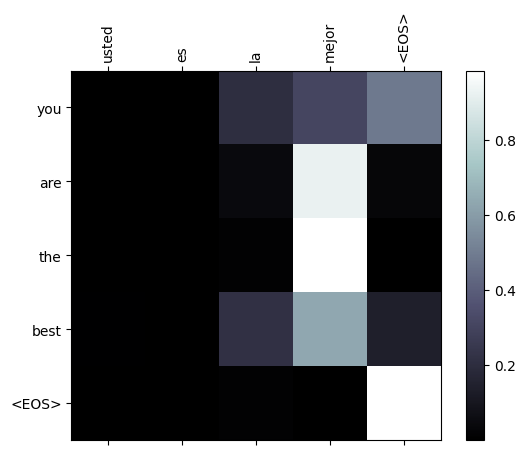

input = estoy bastante cansado
output = i m quite tired <EOS>


<ipython-input-17-110a4424089d>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)  # Etiquetas en el eje X
<ipython-input-17-110a4424089d>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)  # Etiquetas en el eje Y


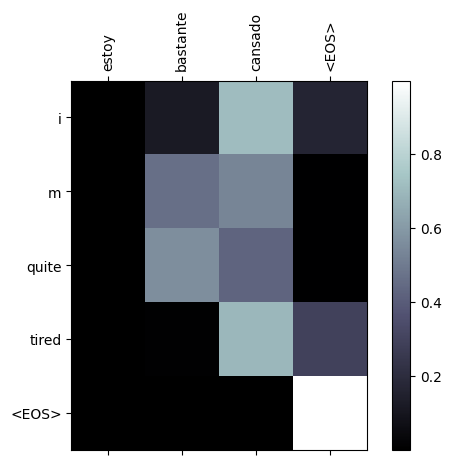

In [ ]:
# Evalúa y muestra la atención para varias frases de ejemplo
if REVERSE_LANG:    # True para lang2 → lang1
  if LANG_2=='ita':
      evaluateAndShowAttention('sei una studentessa')
      evaluateAndShowAttention('ho finito di lavorare')
  else:
      evaluateAndShowAttention('usted es la mejor')
      evaluateAndShowAttention('estoy bastante cansado')
else:               # False para lang1 → lang2
    evaluateAndShowAttention('you re very stylish')
    evaluateAndShowAttention('he is very brave')

## Análisis de Resultados

Este apartado presenta el análisis de los modelos de traducción con atención de Bahdanau, entrenados para realizar traducciones del español al inglés y del italiano al inglés. Se analizaron tanto las métricas de pérdida durante el entrenamiento como los ejemplos de traducción y las matrices de atención generadas.


### Evolución de la Pérdida durante el Entrenamiento

La pérdida de entrenamiento para ambos modelos muestra una disminución consistente a lo largo de las 100 épocas. A continuación, se presentan los detalles de pérdida observados en cada caso:

- **Traducción del español al inglés:** El modelo comenzó con una pérdida de 2.8881 en la primera época y finalizó con una pérdida de 0.0460, lo cual indica que el modelo fue ajustándose adecuadamente a los datos de entrenamiento.
- **Traducción del italiano al inglés:** Para este modelo, la pérdida inicial fue de 1.8760, y después de 100 épocas se redujo a 0.0605. Esta tendencia sugiere una convergencia estable del modelo y un buen ajuste a los datos.


### Análisis de Ejemplos de Traducción

Para evaluar la calidad de las traducciones, se presentan ejemplos de frases de prueba traducidas por ambos modelos.

Hacer **clic** para expandir y ver los ejemplos completos de cada modelo.<BR><BR>

<details>
<summary><strong>Español-->Inglés</strong></summary>
<BR>
> el aun sigue vivo<BR>
= he s still alive<BR>
< he is still alive <EOS><BR>
<BR>
> tu siempre eres bienvenido<BR>
= you are always welcome<BR>
< you are always welcome <EOS><BR>
<BR>
> estoy de vacaciones<BR>
= i m on holiday<BR>
< i m on vacation <EOS><BR>
<BR>
> estan invitados<BR>
= you re invited<BR>
< you re invited <EOS><BR>
<BR>
> estas perdido<BR>
= you re lost<BR>
< you re lost <EOS><BR>
<BR>
> somos prisioneros<BR>
= we re prisoners<BR>
< we re prisoners <EOS><BR>
<BR>
> soy empresario<BR>
...<BR>
> sos muy valiente<BR>
= you are very brave<BR>
< you are very brave <EOS><BR>

</details>

<details>
<summary><strong>Italiano-->Inglés</strong></summary>
<BR>
> sto ancora lavorando<BR>
= i m still working<BR>
< i m still working <EOS><BR>
<BR>
> io sono pulito<BR>
= i m clean<BR>
< i m clean <EOS><BR>
<BR>
> tu non sei diversa<BR>
= you re no different<BR>
< you re no different <EOS><BR>
<BR>
> sono tuoi<BR>
= they re yours<BR>
< they re yours <EOS><BR>
<BR>
> sono ancora frustrata<BR>
= i m still frustrated<BR>
< i m still frustrated <EOS><BR>
<BR>
> sei insolito<BR>
= you re unusual<BR>
< you re unusual <EOS><BR>
<BR>
> io sono una masochista<BR>
...<BR>
> ho quasi trent anni<BR>
= i m almost thirty<BR>
< i m almost thirty <EOS><BR>

</details>
<BR>

**Español a Inglés**
- **Frase en español:** _el aún sigue vivo_ - **Esperada:** _he's still alive_ - **Predicción:** _he is still alive_ - **Análisis:** La predicción es correcta, aunque el modelo utilizó una estructura ligeramente distinta (_he is_ en lugar de _he's_). Esto muestra que el modelo comprende el sentido general de la frase, aunque no siempre use la contracción esperada.

- **Frase en español:** _tú siempre eres bienvenido_ - **Esperada:** _you are always welcome_ - **Predicción:** _you are always welcome_ - **Análisis:** La traducción es exacta, mostrando que el modelo capta bien el significado y estructura la frase de manera natural en inglés.

- **Frase en español:** _estoy de vacaciones_ - **Esperada:** _I'm on holiday_ - **Predicción:** _I'm on vacation_ - **Análisis:** La predicción es adecuada en términos de significado, aunque muestra una diferencia cultural en el uso de palabras (_holiday_ vs _vacation_). Esto sugiere que el modelo puede seleccionar alternativas contextuales correctas, aunque no siempre coincidan con la expresión esperada.

**Italiano a Inglés**
- **Frase en italiano:** _sto ancora lavorando_ - **Esperada:** _I'm still working_ - **Predicción:** _I'm still working_ - **Análisis:** La traducción es completamente precisa, demostrando que el modelo es efectivo en capturar el sentido y la estructura de frases simples en tiempo presente.

- **Frase en italiano:** _io sono pulito_ - **Esperada:** _I'm clean_ - **Predicción:** _I'm clean_ - **Análisis:** La traducción es perfecta. Este ejemplo sugiere que el modelo maneja bien frases en primera persona y con verbos sencillos.

- **Frase en italiano:** _sei insolito_ - **Esperada:** _you're unusual_ - **Predicción:** _you're unusual_ - - **Análisis:** La predicción es exacta, lo que muestra que el modelo también puede capturar adjetivos descriptivos sin dificultad.

<BR>Estos ejemplos indican que los modelos son efectivos en captar el significado de las frases y en general producen traducciones precisas. Sin embargo, las diferencias culturales en el lenguaje (como _holiday_ vs _vacation_) y ligeras variaciones en la estructura (_he's_ vs _he is_) son áreas que pueden mejorarse. En contextos más complejos o expresiones menos literales, puede ser útil entrenar con datasets más grandes y variados para captar mejor estas sutilezas del idioma.



### Análisis de las Matrices de Atención

Las matrices de atención muestran cómo el modelo presta atención a diferentes palabras en la oración de entrada en español e italiano al generar cada palabra en la traducción en inglés. Esto es fundamental para entender el alineamiento y cómo el modelo maneja frases de longitud y estructura variadas. Las matrices de atención indican que el modelo puede concentrarse en las palabras correctas al traducir.
<BR><BR>

**Español a Inglés**
- En el ejemplo "_usted es la mejor_" traducido como "_you are the best_", la matriz de atención muestra una fuerte alineación con las palabras correspondientes, particularmente en "_la mejor_" con "_the best_".
- En el ejemplo "_estoy bastante cansado_" traducido como "_i'm quite tired_", se observa una atención adecuada en las palabras de la frase en español que ayuda a mantener la traducción precisa y fiel al contexto en inglés.

**Italiano a Inglés**
- En el ejemplo "_sei una studentessa_" traducido como "_you are a student_", la matriz de atención destaca cómo el modelo alinea correctamente "_studentessa_" con "_student_", lo que demuestra una adecuada correspondencia entre las palabras en ambos idiomas, a pesar de las diferencias de género y estructura gramatical entre el italiano y el inglés.
- En el ejemplo "_ho finito di lavorare_" traducido como "_i'm done working_", la atención se distribuye correctamente en "_finito_" y "_done_", así como en "_lavorare_" y "_working_", capturando el significado completo de la frase en italiano y alineándolo con precisión en inglés.


<BR>Estas matrices de atención refuerzan que el modelo de atención de Bahdanau es efectivo al asignar atención a las palabras correctas en idiomas con diferencias estructurales, como el español, el italiano y el inglés.


### Conclusiones y posibles mejoras

El modelo con atención Bahdanau para la traducción de español a inglés ha demostrado ser efectivo, produciendo resultados precisos y alineados con las expectativas de traducción. La pérdida de entrenamiento baja y las matrices de atención consistentes reflejan un aprendizaje satisfactorio del modelo en el conjunto de datos de entrenamiento.

En el caso de la traducción de italiano a inglés, el modelo también ha mostrado un rendimiento sólido. Las traducciones generadas son coherentes y la atención se distribuye adecuadamente, capturando la estructura y el significado de las frases en italiano al convertirlas al inglés. Las matrices de atención destacan cómo el modelo logra una alineación adecuada, incluso en casos donde existen diferencias gramaticales y estructurales entre el italiano y el inglés, lo cual indica que el modelo ha capturado bien las relaciones semánticas entre ambos idiomas.

Para mejorar aún más el rendimiento en ambos casos:
- **Ampliar el conjunto de datos**: Incrementar el número de pares de frases de entrenamiento podría mejorar la capacidad generalizadora del modelo, especialmente en frases más complejas o menos comunes.
- **Aumentar el número de épocas**: Entrenar durante más épocas podría mejorar el ajuste del modelo, aunque se debe tener cuidado con el sobreajuste.
- **Ajustar hiperparámetros**: Experimentar con tamaños de capa oculta más grandes o ajustar la tasa de aprendizaje podría ayudar al modelo a capturar mejor las relaciones complejas en las frases.
  
